Vybraná okénková funkce: [Hann window](https://en.wikipedia.org/wiki/Window_function#Hann_and_Hamming_windows)  
![Vzorec funkce](https://wikimedia.org/api/rest_v1/media/math/render/svg/cd8d3e844a1443d7bedd57240588cf19fcd28af1)


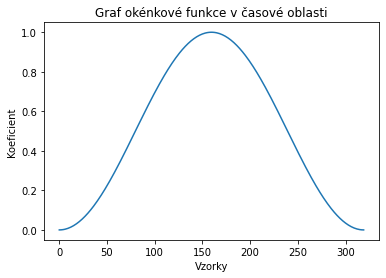

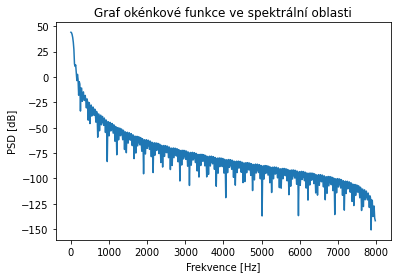

In [1]:
import numpy as np
import matplotlib.pyplot as plt

wind = np.hanning(320)

plt.plot(wind)
plt.gca().set_xlabel('Vzorky')
plt.gca().set_ylabel('Koeficient')
plt.gca().set_title("Graf okénkové funkce v časové oblasti")

windFFT = np.fft.fft(wind,1024)
plt.figure()
plt.gca().set_ylabel('PSD [dB]')
plt.gca().set_xlabel('Frekvence [Hz]')
plt.gca().set_title("Graf okénkové funkce ve spektrální oblasti")

plt.plot(np.arange(0,8000, 8000/512),20*np.log10(np.abs(windFFT[0:512])))

## Použití funkce

In [2]:
%run spectrograms.py

def getWindowedSpectrogram(corrCoeficients):
    spectrs = []
    freqs = np.empty([100,1024], dtype=np.complex_)
    for i, corr in enumerate(corrCoeficients):
        paddedFFT = np.fft.fft(corr * wind,1024)
        spectrs.append(20*np.log10((np.abs(paddedFFT[0:512]))))
        freqs[i] = paddedFFT
    return spectrs, freqs

TMN_spect, TMN_freq = getWindowedSpectrogram(TMNframes)
TMN_windowless, _ = getSpectrogram(TMNframes)
TMF_spect, TMF_freq = getWindowedSpectrogram(TMFframes)
TMN_trans = np.transpose(TMN_spect)
TMF_trans = np.transpose(TMF_spect)

Normalizovaný rozsah:  -0.9571755495534905 1.0
Normalizovaný rozsah:  -0.7997674977486542 1.0
minLag:  32
F0 =  121.21212121212122
maxIndex =  132


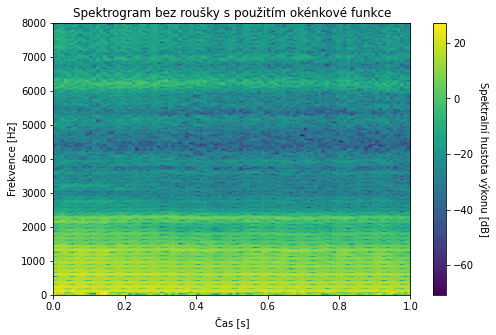

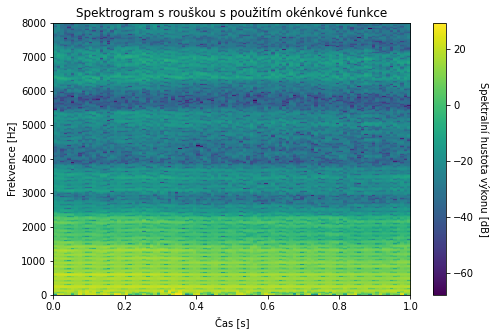

In [3]:
plt.rcParams["image.interpolation"] = 'nearest'
plt.gca().set_title('Spektrogram bez roušky s použitím okénkové funkce')
plt.gca().set_xlabel('Čas [s]')
plt.gca().set_ylabel('Frekvence [Hz]')
plt.imshow(TMF_trans, origin='lower', aspect='auto', extent = [0 , 1.0, 0 , 8000])
cbar = plt.colorbar()
cbar.set_label('Spektralní hustota výkonu [dB]', rotation=270, labelpad=15)
plt.figure()

plt.gca().set_title('Spektrogram s rouškou s použitím okénkové funkce')
plt.gca().set_xlabel('Čas [s]')
plt.gca().set_ylabel('Frekvence [Hz]')
plt.imshow(TMN_trans, origin='lower', aspect='auto', extent = [0 , 1.0, 0 , 8000])
cbar = plt.colorbar()
cbar.set_label('Spektralní hustota výkonu [dB]', rotation=270, labelpad=15)

## Porovnání
Fourierova transofrmace předpokládá periodický signál. Na začátku a konci rámce se proto v časové oblasti vytvoří skok. Okénková funkce tento skok eliminuje a proto je výsledné spektrum vyhlazenější.

## Spektra rámce 1


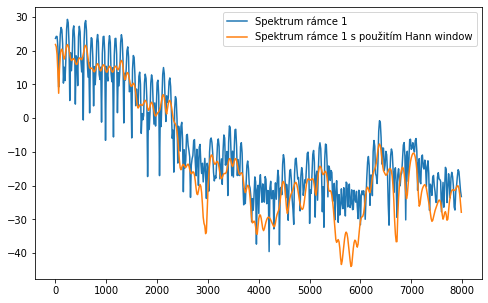

In [4]:
plt.plot(np.arange(0,Fs/2, Fs/2/512),TMN_windowless[1], label="Spektrum rámce 1")
plt.plot(np.arange(0,Fs/2, Fs/2/512),TMN_spect[1], label="Spektrum rámce 1 s použitím Hann window")

plt.legend()

## Frekvenční charaktersitika filtru

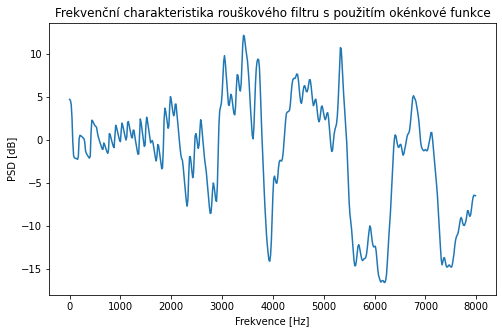

In [5]:
TMF_ave = prumerCharakteristiky(TMF_freq)
TMN_ave = prumerCharakteristiky(TMN_freq)

H = TMN_ave/TMF_ave

H_PSD = 20*np.log10(np.abs(H[0:512]))
H = np.divide(TMN_ave,TMF_ave)

plt.gca().set_title('Frekvenční charakteristika rouškového filtru s použitím okénkové funkce')
plt.gca().set_ylabel('PSD [dB]')
plt.gca().set_xlabel('Frekvence [Hz]')
plt.plot(np.arange(0,Fs/2, Fs/2/512),H_PSD)

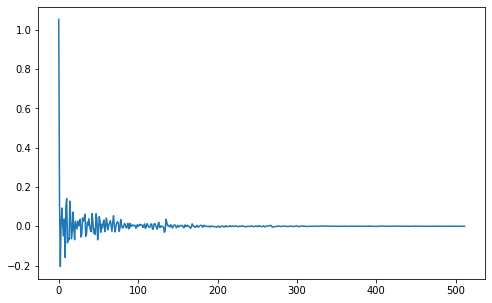

In [6]:
# Apliakce impluzní odezvy a uložení souborů
H_ifft = np.fft.irfft(H,1024)
plt.plot(H_ifft[0:512], label="np.fft.ifft")

from scipy import signal
_, sentence = wavfile.read('../audio/maskoff_sentence.wav')
_, sentence_on = wavfile.read('../audio/maskon_sentence.wav')
senNorm = np.max(np.abs(sentence))
toneNorm = np.max(np.abs(tmf))
sentence_sim = signal.lfilter(H_ifft[0:512], [1], sentence)
tone_sim = signal.lfilter(H_ifft[0:512], [1], tmf)

import soundfile as sf
sf.write('../audio/sim_maskon_sentence_window.wav', sentence_sim / 32767, int(Fs))
sf.write('../audio/sim_maskon_tone_window.wav', tone_sim / 32767, int(Fs))

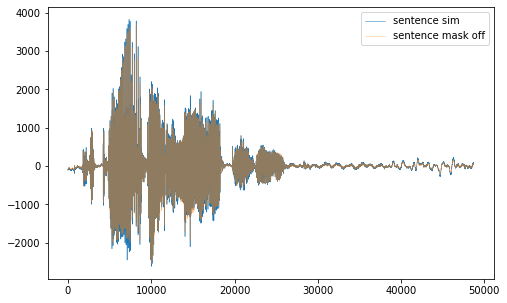

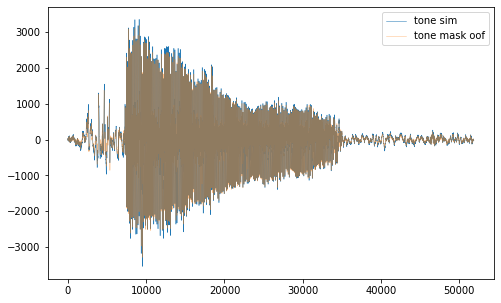

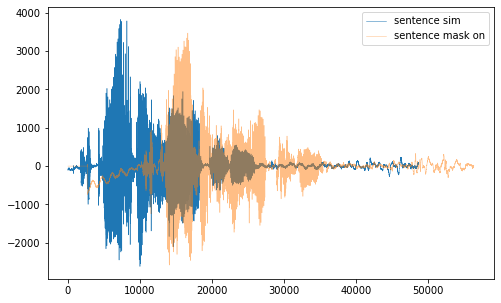

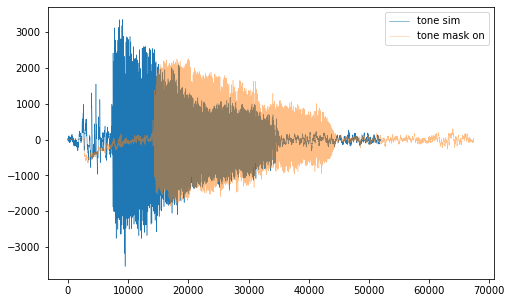

In [7]:
plt.plot(sentence_sim, linewidth=0.5,label="sentence sim")
plt.plot(sentence,linewidth=0.5,alpha=0.5, label="sentence mask off")
plt.legend()

plt.figure()
plt.plot(tone_sim, linewidth=0.5, label="tone sim")
plt.plot(tmf, linewidth=0.5,alpha=0.5, label="tone mask oof")
plt.legend()

plt.figure()
plt.plot(sentence_sim, linewidth=0.5, label="sentence sim")
plt.plot(sentence_on,linewidth=0.5,alpha=0.5, label="sentence mask on")
plt.legend()

plt.figure()
plt.plot(tone_sim, linewidth=0.5, label="tone sim")
plt.plot(tmn, linewidth=0.5,alpha=0.5,label="tone mask on")
plt.legend()